# Starbucks Capstone Challenge

### Project Overview
This is the Capstone Project of Udacity's Data Scientist ND.
The given data are related to Starbucks' customers and offers. Starbucks has a mobile app that once every few days sends an offer to the customers. The offers could be Buy One Get One (BOGO), or just a discount. The app keeps the records of the offers, Transactions and Whether an offer has been completed. In addition, the app has some data about the customers like age and income.

The provided datasets are:
* portfolio : containing offer ids and meta data about each offer (duration, type, etc.).
* profile : demographic data for each customer.
* transcript : records for transactions, offers received, offers viewed, and offers completed.


### Problem Statement
The scope of this project is to look closer at the data and see how the group of customers that is responsible of 80% of the total sales are different than the rest. This will be done without any ML models.

This will be done by the following steps:
* Quick look at the customers in general.
* Process the data to get each Customer's spendings.
* Split the Customers to two groups, a group that has a Contribution of 80% of the total sales and the other group will be the rest.
* The two goup will be compared by the following:
    * Age
    * Genders Distribution
    * Income Distribution
    * Their interactions with the offers
    * The total reward of each group

### Metrics

The metrics will be either percentage or meam

# Data Sets in Details

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Analysis

## Initial Assessment 

In [1]:
# Importing the needed libraries
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
# Looking at the portfolio data set
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
portfolio.shape

(10, 6)

> We have 10 offers and three types of offers, which are BOGO, Discount and Informational

In [4]:
# Looking at the profile data set
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
profile.shape

(17000, 5)

In [6]:
# How many missing values we have in the profile dataset
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

> We have 17k costumers with the gender, age and income informaiton. We notice that we have outliers and missing fields.

In [7]:
# Looking at the transcript dataset 
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [8]:
transcript.shape

(306534, 4)

> We have 300k transactions with costumer id, offer id and the time.

# Exploring the Costumers in General

#### In this section, the customers will be explored in several aspects. As per the provided data, these attributes will be explored:
* Age.
* Income.
* Gender.

## Age

In [9]:
# Getting the age column 
cust_age = profile.age

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

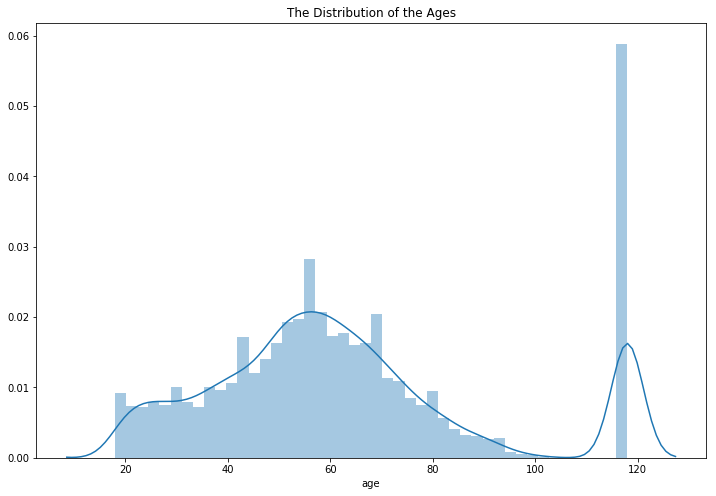

In [67]:
# Plotting a histogram for the ages
plt.figure(figsize=(12,8));
sns.distplot(cust_age)
plt.title('The Distribution of the Ages')
cust_age.describe()

In [11]:
print ('There are {} customers with an age of 118'.format((cust_age == 118).sum()))

There are 2175 customers with an age of 118


### Observations
* We see that we have outliers, people are registered with an age of 118. While it is not an outlier as an age, but having more than 2000 customers with this age does not seem to be right. I would assume that it is the Default birth day when a new customer register in the app. That would be around the year of 1900. This require a closer look.
* There are no missing values.

In [12]:
# Looking at these customer with an age of 118 closer
profile[profile['age']==118].head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


In [13]:
# It seems that these customers are not giving their income nor gender
profile[profile['age']==118].count()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

> As expected, these are considered as noise and should be deleted. However, they will be kept to see if these customer have something in common and help Starbucks in treating them differently.

### Final Thoughts
It was expected to have most of the customers with an age less than 35, but the data shows that most customers are above 40 and 50. This was not expected for two reasons:
1. Using an app should be more common among the yound generation.
2. Drinking coffee regularly is a known habits of the yound generation, especially students and employees.

## Income

In [14]:
# Getting the income
cust_income = profile.income

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

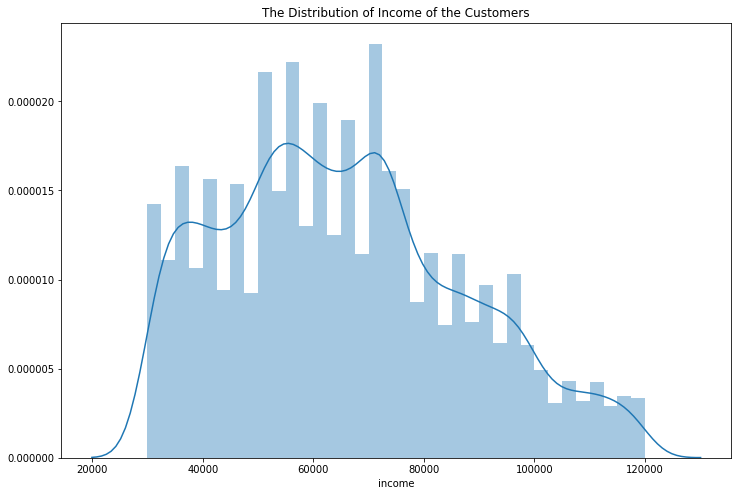

In [71]:
# plotting the income distribution 
plt.figure(figsize=(12,8))
sns.distplot(cust_income.dropna())
plt.title('The Distribution of Income of the Customers');
cust_income.describe()



In [16]:
print ("There are {} missing values".format(cust_income.isna().sum()))

There are 2175 missing values


### Observations
* There are no outliers
* The missing values are related to those with the age of 118.

### Final Thoughts
The income, has a fairly flat distribution up to 75k, and then it start to get lower and lower, which is expected. This till us that we have a wide range of customers when it comes to the income, so this can be used in making some special offers for each group of income.

## Gender

In [17]:
cust_gender = profile.gender

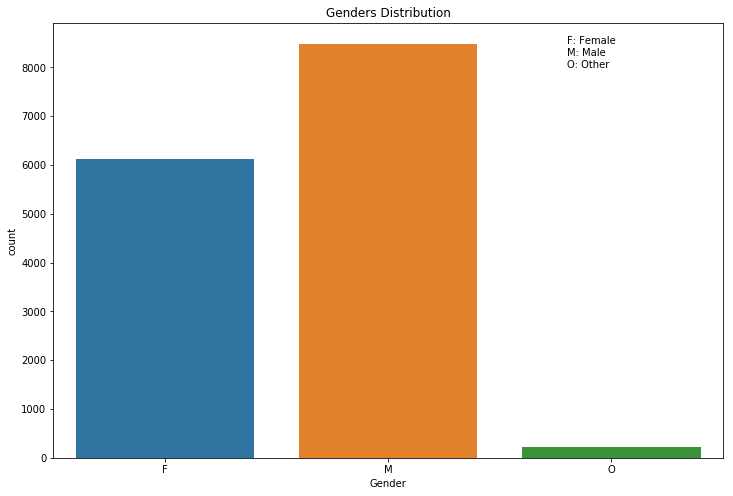

In [79]:
plt.figure(figsize=(12,8))
sns.countplot(cust_gender)
plt.xlabel('Gender')
plt.text(1.8,8000, s = 'F: Female \nM: Male \nO: Other');
plt.title('Genders Distribution');

### Observations
* There is no significant Domination of any gender, even though Males are the Majorities, but the difference is not huge.

# Exploring the Transcript

In [19]:
# Quick look
transcript.sample(5)

,event,person,time,value
116384,offer received,9b42f9e0dc2e465982845e31f0b5c02d,336,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
268805,offer viewed,b5b515ff26234d548bad3558992d1389,588,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
186745,transaction,07c44df054f241aab553723ed855ca21,450,{'amount': 10.67}
6077,offer received,8db30a2bb6834567885d0ba2c442774e,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
109840,transaction,d93aac1763804476bac97bbf6b76017f,324,{'amount': 1.81}


In [20]:
# Looking at the event column
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

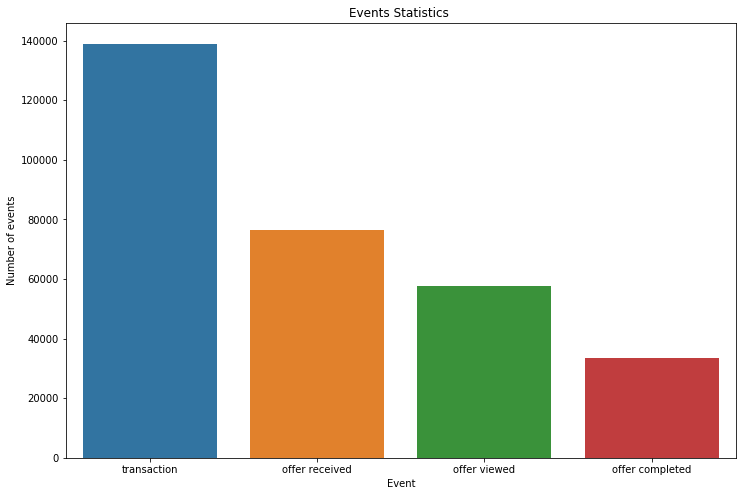

In [83]:
# Plotting
plt.figure(figsize=(12,8))
sns.barplot(transcript.event.value_counts().index, transcript.event.value_counts().values)
plt.ylabel('Number of events')
plt.xlabel('Event')
plt.title('Events Statistics ');

In [22]:
# Checking missing values
transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [23]:
# Checking duplicates
transcript.columns.duplicated().sum()

0

In [24]:
print ('The percentage of the offers that were completed is {0:0.2f}%'.format(
    transcript.event.value_counts()['offer completed']/transcript.event.value_counts()['offer received']*100))

The percentage of the offers that were completed is 44.02%


In [25]:
print ('The percentage of the offers that were received and viewed is {0:0.2f}%'.format(
    transcript.event.value_counts()['offer viewed']/transcript.event.value_counts()['offer received']*100))

The percentage of the offers that were received and viewed is 75.68%


### Observations
* We see that out of the received offers, 75% were viewed, but only 44% were completed. We need more Manipulations to see how many offers were viewed and completed and not viewed but completed.

# Analyzing and Grouping the Customer

In this section, I will find create a new column named 'amount' and 'reward'. The first will give me the group of customers that are responsible of 80% of the sales. The second will show which group is gettin more rewards.

In [26]:
# Initiation of the columns with zeros
transcript['amount'] = 0  
transcript['reward'] = 0  

In [27]:
# Getting the amount and reward from the value column. It is Dictionary, it need an Iteration 
for idx, row in transcript.iterrows():
    for k in row['value']:
        if k == 'amount':
            transcript.at[idx, 'amount'] = row['value'][k]
        if k == 'reward':
            transcript.at[idx, 'reward'] = row['value'][k]

In [28]:
# Checking that it worked 
transcript.sample(5)

,event,person,time,value,amount,reward
266320,transaction,1b60c7f201324499ae707537200b5934,588,{'amount': 23.79},23,0
16708,transaction,db06532760134014aa9445c7560554af,6,{'amount': 15.22},15,0
85587,offer completed,b4360ed1ef1147d3acdc322dc98e0811,216,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,0,5
245911,offer received,7a5f837ad609476cb17734d90f2e0ed8,576,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0
156875,offer received,26c3b335700e432d9e2c7d3b4808c197,408,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,0


In [29]:
# to get the how much each person has spent, I should group by person and take the sum of the amount column
cust_spending = transcript[['person','amount']].groupby('person').sum().sort_values('amount', ascending = False).reset_index('person')
cust_spending.rename(mapper={'amount':'spent'}, axis = 1, inplace = True)

count    17000.000000
mean       100.437353
std        125.039802
min          0.000000
25%         18.000000
50%         65.000000
75%        144.000000
max       1606.000000
Name: spent, dtype: float64

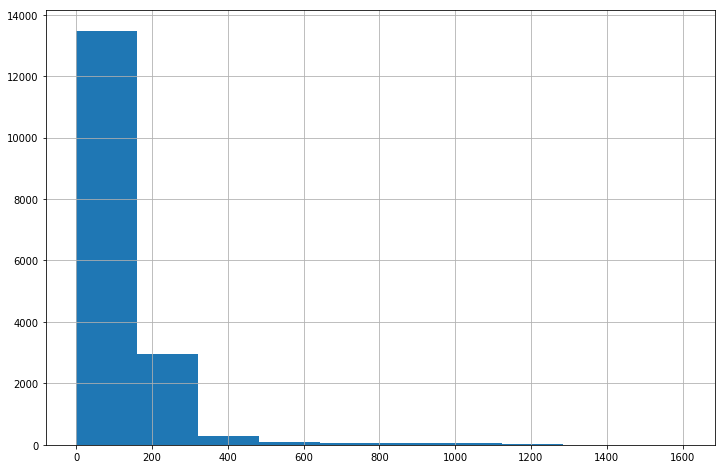

In [30]:
# plotting a histogram of the spendings
cust_spending.spent.hist(figsize = (12,8))
cust_spending.spent.describe()

In [31]:
# How much has the customers spent?
total_spent = cust_spending.spent.sum()
print('The toal amount spent is ${}'.format(total_spent))

The toal amount spent is $1707435


Now I want to have the group that is responsible of the 80% of the sales

In [32]:
spent_80_total = 0
spent_80_cut = 0

In [33]:
for i in cust_spending.spent:
    spent_80_total+=i
    if spent_80_total >= 0.8*total_spent:
        spent_80_cut = i
        break

In [34]:
# Checking that it is indeed 80%
spent_80_total/total_spent

0.80004158284209936

In [35]:
# This is the cut-off spending
spent_80_cut

97

In [36]:
# Forming the first group
spent_80_cust = cust_spending[cust_spending['spent']>97]

In [37]:
spent_80_cust.head()

,person,spent
0,3c8d541112a74af99e88abbd0692f00e,1606
1,f1d65ae63f174b8f80fa063adcaa63b7,1360
2,ae6f43089b674728a50b8727252d3305,1320
3,73afdeca19e349b98f09e928644610f8,1314
4,626df8678e2a4953b9098246418c9cfa,1314


In [38]:
# Checking again and it almost 80%
spent_80_cust.spent.sum()/ total_spent

0.79799640981940745

In [39]:
# Forming the second group
spent_20_cust = cust_spending[cust_spending['spent']<=97]

In [40]:
spent_20_cust.head()

,person,spent
6658,4a4d6200c3fb49ffa5a6cb3fbb19073d,97
6659,149f67791ca9431bb9c27f9f59a4435a,97
6660,9b42f9e0dc2e465982845e31f0b5c02d,97
6661,9bf80936b4d3429aa4e85cdf39b3c369,97
6662,cb9a02105ed948fc8f7e45f934e56c79,97


In [41]:
# Checking it is 20%
spent_20_cust.spent.sum()/ total_spent

0.20200359018059252

In [42]:
spent_20_cust.shape

(10342, 2)

In [43]:
spent_20_cust.shape[0]/cust_spending.shape[0]

0.6083529411764705

In [44]:
spent_80_cust.shape[0]/cust_spending.shape[0]

0.3916470588235294

We see that 80% of the sales are coming from 40% of the customers. This shows that there is a major number of customers whom contribution is very low.

### Now let's try to see if there is any special features of each group

In [45]:
# Joining the customer with their profiles
cust_spending_80 = spent_80_cust.join(profile)

In [46]:
cust_spending_20 = spent_20_cust.join(profile)

In [47]:
cust_spending_80.describe()

,spent,age,became_member_on,income
count,6658.000000,6658.000000,6.658000e+03,5816.000000
mean,204.645089,62.677080,2.016692e+07,65536.623109
std,144.517561,26.535675,1.180842e+04,21458.184653
min,98.000000,18.000000,2.013073e+07,30000.000000
25%,129.000000,46.000000,2.016052e+07,50000.000000
50%,165.000000,58.000000,2.017080e+07,64000.000000
75%,223.000000,73.000000,2.017123e+07,80000.000000
max,1606.000000,118.000000,2.018073e+07,120000.000000


In [48]:
cust_spending_20.describe()

,spent,age,became_member_on,income
count,10342.000000,10342.000000,1.034200e+04,9009.000000
mean,33.350222,62.437633,2.016711e+07,65320.013320
std,27.636088,26.869257,1.159245e+04,21689.037392
min,0.000000,18.000000,2.013073e+07,30000.000000
25%,11.000000,45.000000,2.016053e+07,49000.000000
50%,24.000000,58.000000,2.017080e+07,63000.000000
75%,53.000000,73.000000,2.017123e+07,79000.000000
max,97.000000,118.000000,2.018073e+07,120000.000000


Looking at the Statistics, there are no obvious differences. However, let's see the histograms.

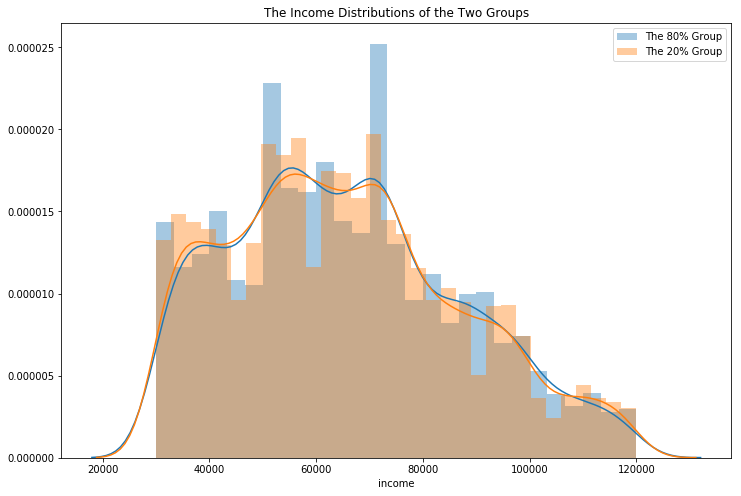

In [49]:
# Plotting Histograms
plt.figure(figsize = (12,8))
sns.distplot(cust_spending_80.income.dropna())
sns.distplot(cust_spending_20.income.dropna())
plt.legend(["The 80% Group","The 20% Group"])
plt.title('The Income Distributions of the Two Groups');

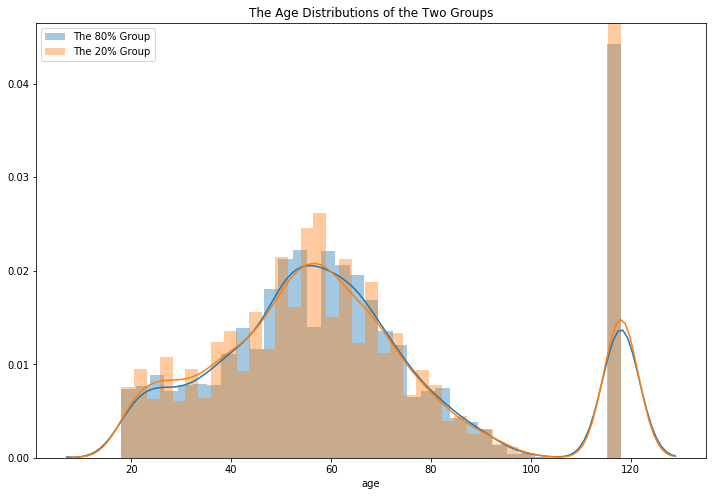

In [50]:
plt.figure(figsize = (12,8))
sns.distplot(cust_spending_80.age)
sns.distplot(cust_spending_20.age)
plt.legend(["The 80% Group","The 20% Group"])
plt.title('The Age Distributions of the Two Groups');

It is strange that there are no real differences between the two groups, all metrics are very similar

### Let's see how they are have interacted with the offers

In [51]:
# Getting the list of the customers 
cust_80_list = cust_spending_80.person.tolist()
cust_20_list = cust_spending_20.person.tolist()

In [52]:
# Forming the transcripts from using the Customer lists
transcript_80 = transcript[transcript['person'].isin(cust_80_list)]
transcript_20 = transcript[transcript['person'].isin(cust_20_list)]

In [53]:
transcript_80.sample(5)

,event,person,time,value,amount,reward
245170,offer received,3a1242dda16248728e350c4bdeb21972,576,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0
116081,offer received,4468048bdc5548238d2ee46de738eb39,336,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0
301783,transaction,43ed353933c144caa4efffd219bb17a1,690,{'amount': 26.51},26,0
229484,transaction,805576ae0d834276b5c1fdc86b1fca73,528,{'amount': 19.01},19,0
138765,offer completed,e125bb8eda2c4e0eb264a1281c872110,366,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...,0,5


In [54]:
# Getting the event counts
r80 = transcript_80.event.value_counts()

In [55]:
r20 = transcript_20.event.value_counts()

In [56]:
r80.head()

transaction        67808
offer received     30443
offer viewed       24318
offer completed    21887
Name: event, dtype: int64

In [57]:
# Calculating the percentages
seen_offer_80 = r80[2]/r80[1]
completed_offer_80 = r80[3]/r80[1]
completed_seen_offer_80 =  r80[3]/r80[2]

In [58]:
seen_offer_20 = r20[2]/r20[1]
completed_offer_20 = r20[3]/r20[1]
completed_seen_offer_20 =  r20[3]/r20[2]

In [59]:
# Creating a dataframe for the percentages 
records_df = pd.DataFrame(columns= ['offers_viewed', 'offers_completed', 'offer_viewed_completed'],
                         index = ['80', '20'])

In [60]:
records_df.iloc[1] = [seen_offer_20,completed_offer_20,completed_seen_offer_20]

In [61]:
records_df.iloc[0]=[seen_offer_80,completed_offer_80,completed_seen_offer_80]

In [62]:
# Printing the dataframe to see the results
records_df

,offers_viewed,offers_completed,offer_viewed_completed
80,0.798804,0.71895,0.900033
20,0.728869,0.255094,0.349987


There is a Significant difference between the two groups, almost all the 80% group have completed the offer when seen, while only one-third of the other group did. In addition, 71% of the 80% group have completed the offers they had received compared to 25% in the other group.

This shows that those who contributed to most of the sales are getting advantage of the offers and the other group are not. We could say that we should stop sending offers to the 20% group, because they seem to ignore the offers and buy regardless. 

### Caveat!

Even though the 80 group have spent so much, but also they have been Rewarded so much. Almost 69% of the total rewards were given to this group that makes around 40% of the total customers. This needs more details on how profitable they are, are they really bringing profits or not, and if they do is higher than the other group? It is possible that the other group is more profitable becuse they do not complete offers and buy with the full price.

### Looking at the customers who didn't care about filling the application form

In [63]:
print('{0:0.2f}% of the total rewards were given to the 80 group'
      .format(transcript_80.reward.sum()/(transcript_20.reward.sum()+transcript_80.reward.sum())*100))

68.69% of the total rewards were given to the 80 group


In [64]:
cust_spending_80.isnull().sum()

person                0
spent                 0
age                   0
became_member_on      0
gender              842
id                    0
income              842
dtype: int64

In [65]:
cust_spending_20.isnull().sum()

person                 0
spent                  0
age                    0
became_member_on       0
gender              1333
id                     0
income              1333
dtype: int64

The majority of those who didn't fill the application carefully are not active customers. So if Starbucks got such a customer, they should not invest alot in him.

# Conclusion

80% of the total sales are comming from 40% of the customers. Looking closer at this valuable group, we found that it doesn't differ from the other group in term of Age and Income, both have a very similar distributions. However, we found that there are customers who register without giving filling the application correctly, they leave the default age and ignore the income and gender. Most of these customers are not in the Valuable group. So we can say that if a customer is giving false data, then probably he is not going to be a profitable customer. Furthermore, these valuable customers are taking almost a full Advantage of the offers. This needs more information to decide if they are bringing profit or not. As a result, more than two-third of the total rewards were given to this group.

# Improvements
As state before, the differences between the two groups are not clear. Therefore, more Features are need. One possible features would be knowing when the offer was seen after it had been received could further help differentiating between the two groups. For example, it is possible that the valuable group are always looking for the offers and thus the time between receiving and viewing the offer is very short when compared to the second group. This will help a ML model to classify new customers as well. 